# Second Level GLMs - Active vs. Sham

In [1]:
import os, glob
import numpy as np
import pandas as pd

from src.my_settings import settings

from nilearn import plotting as nlp
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel

from nilearn.reporting import get_clusters_table
from mni_to_atlas import AtlasBrowser
atlas = AtlasBrowser("AAL3")

In [2]:
# Settings
sett = settings()

contrast_name = 'MotorImageryMinusRest'

In [3]:
# List all zmap nii.gz files
zmap_nf_files = glob.glob(
    os.path.join(sett["out_glm_path"],
        f"sub-*_task-nf_stat-z_con-{contrast_name}.nii.gz"
    )
)
zmap_nf_files.sort()

zmap_sham_files = glob.glob(
    os.path.join(sett["out_glm_path"],
        f"sub-*_task-sham_stat-z_con-{contrast_name}.nii.gz"
    )
)
zmap_sham_files.sort()

n_subjects = len(zmap_nf_files)
print(f"Found {n_subjects} subjects")

Found 22 subjects


In [4]:
# join the two lists
second_level_input = zmap_nf_files + zmap_sham_files

In [5]:
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = [f"S{i:02d}" for i in range(1, n_subjects + 1)]

In [6]:
paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["activeVSsham"] + subjects,
)

<Axes: label='conditions', ylabel='scan number'>

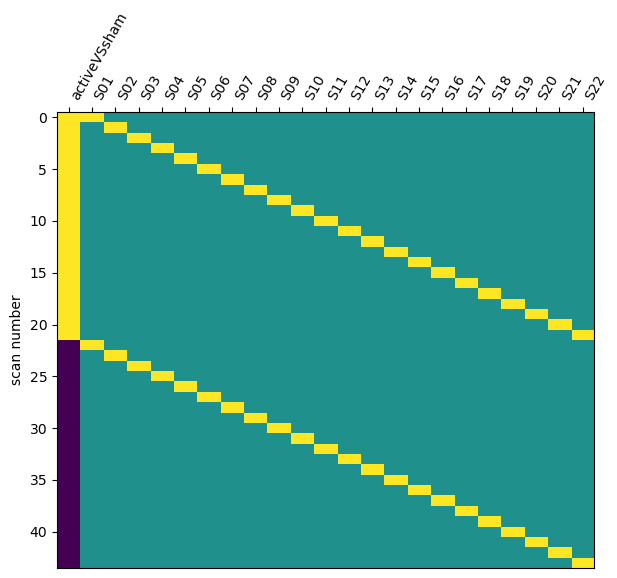

In [7]:
# plot design matrix
nlp.plot_design_matrix(paired_design_matrix, rescale=False)

In [8]:
second_level_model_paired = SecondLevelModel(n_jobs=2, smoothing_fwhm=8).fit(
    second_level_input, design_matrix=paired_design_matrix
)

In [9]:
stat_maps_paired = second_level_model_paired.compute_contrast(
    "activeVSsham", output_type="all"
)

In [10]:
stat_maps_paired

{'z_score': <nibabel.nifti1.Nifti1Image at 0x309a95d00>,
 'stat': <nibabel.nifti1.Nifti1Image at 0x309c29e20>,
 'p_value': <nibabel.nifti1.Nifti1Image at 0x309c29760>,
 'effect_size': <nibabel.nifti1.Nifti1Image at 0x309c29d90>,
 'effect_variance': <nibabel.nifti1.Nifti1Image at 0x309c29eb0>}

threshold: 2.575829303548901


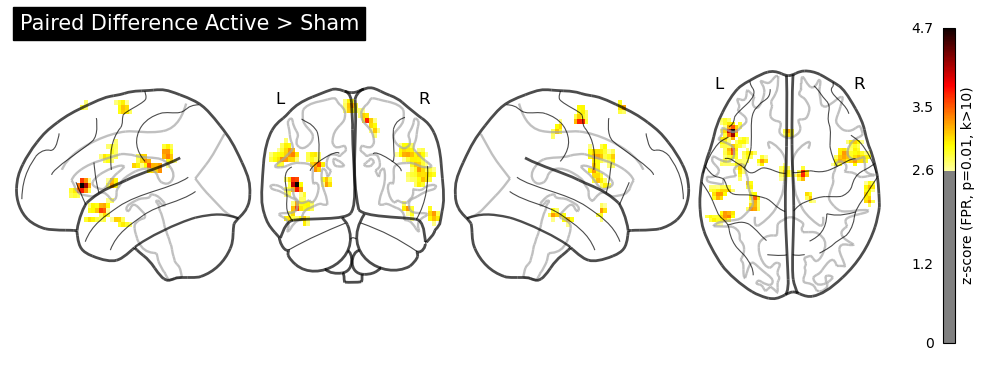

In [11]:
# threshold image
ct = 10
alpha = 0.01
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired["z_score"], cluster_threshold=ct, alpha=alpha, height_control=hc)

print(f"threshold: {thres}")

display = nlp.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    display_mode='lyrz', 
    title='Paired Difference Active > Sham'
)

# Add colorbar text
colorbar = display._cbar
colorbar.set_label('z-score (FPR, p=0.01, k>10)')

In [12]:
table_g,cluster_map_g = get_clusters_table(stat_maps_paired["z_score"], stat_threshold=thres, cluster_threshold=ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table_g['AAL3'] = aal_labels
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-45.0,27.0,5.79,4.688243,1508,Frontal_Inf_Tri_L
1,2,12.0,-9.0,57.66,3.716445,1687,Supp_Motor_Area_R
2,2a,-3.0,-6.0,69.63,3.138019,,Supp_Motor_Area_L
3,3,-45.0,12.0,-14.16,3.614021,2010,Temporal_Pole_Sup_L
4,3a,-51.0,21.0,-22.14,3.050288,,Undefined
5,3b,-36.0,18.0,-10.17,2.966120,,Insula_L
6,4,-27.0,-27.0,21.75,3.533761,969,Undefined
7,4a,-30.0,-36.0,17.76,3.328657,,Undefined
8,4b,-33.0,-15.0,21.75,3.091562,,Insula_L
9,5,-48.0,-42.0,29.73,3.384554,1867,SupraMarginal_L


In [13]:
table_g.to_clipboard()

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



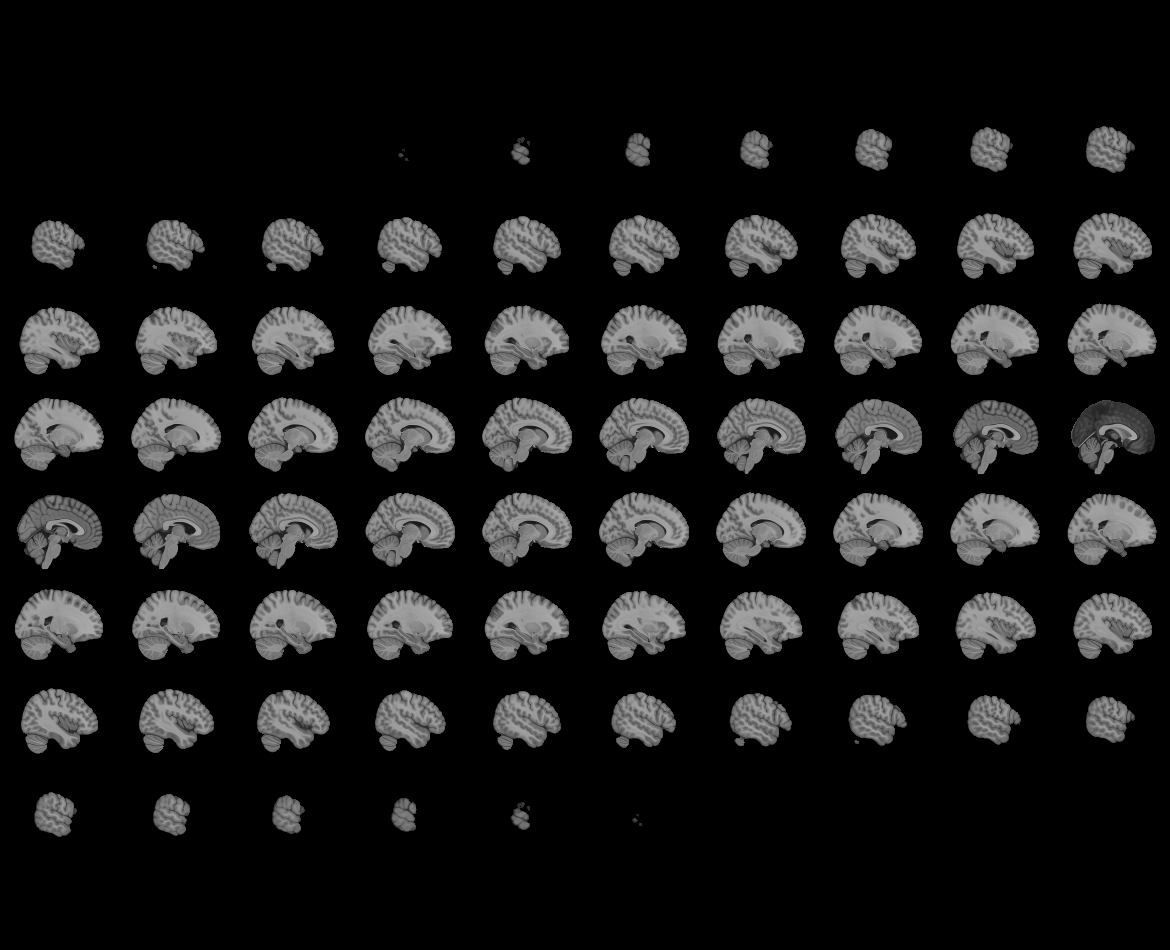
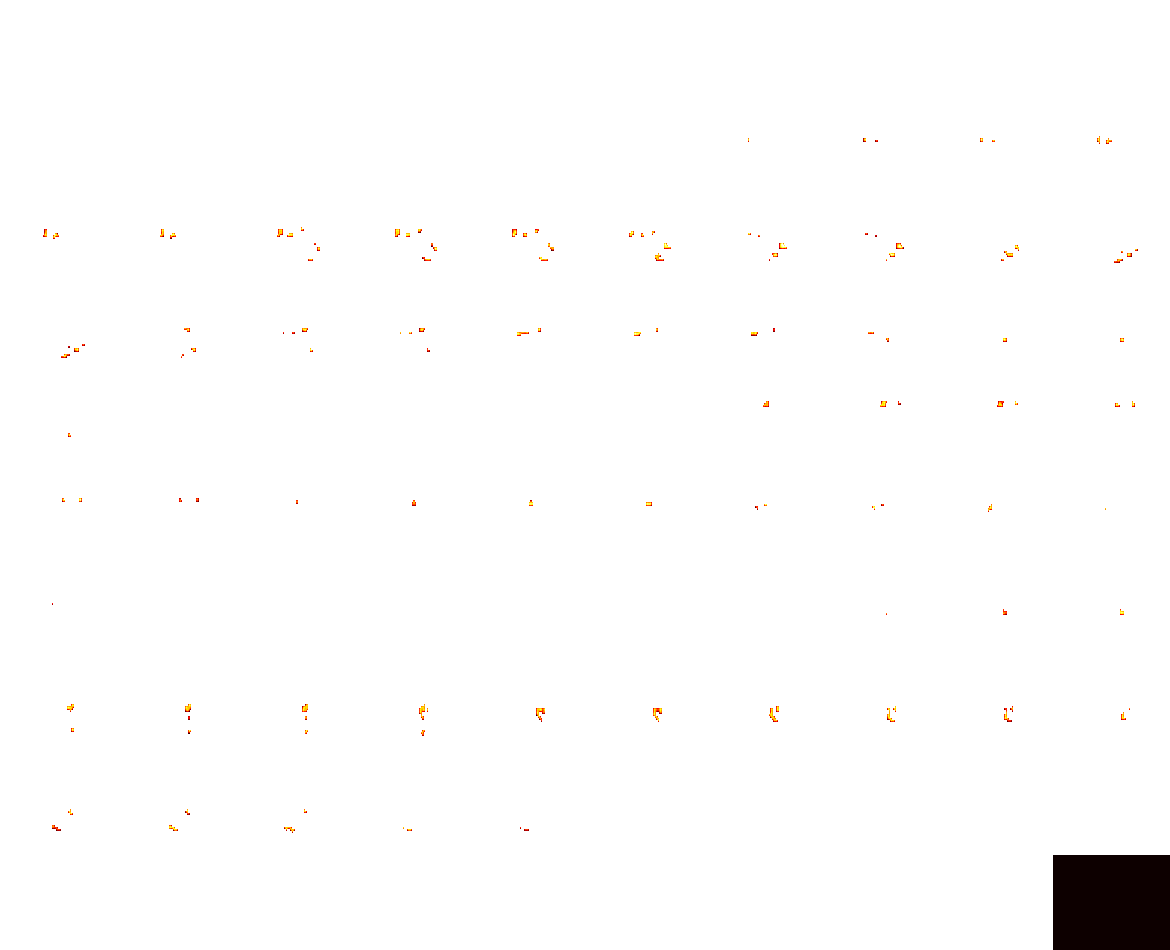

In [14]:
nlp.view_img(corrected_map, threshold=thres, colorbar=True)

# Reward ROI from Neurosynth

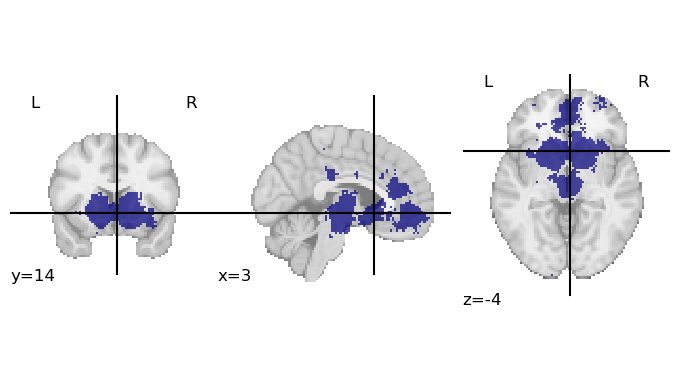

In [15]:
# load and binarize the roi
from nilearn.image import math_img

roi_path = os.path.join(sett["git_path"], "data", "reward_association-test_z_FDR_0.01.nii.gz")
roi_bin = math_img("img > 0", img=roi_path)

nlp.plot_roi(roi_bin)

In [16]:
second_level_model_paired_masked = SecondLevelModel(n_jobs=2, smoothing_fwhm=8, mask_img=roi_bin).fit(
    second_level_input, design_matrix=paired_design_matrix
)

stat_maps_paired_masked = second_level_model_paired_masked.compute_contrast(
    "activeVSsham", output_type="all"
)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



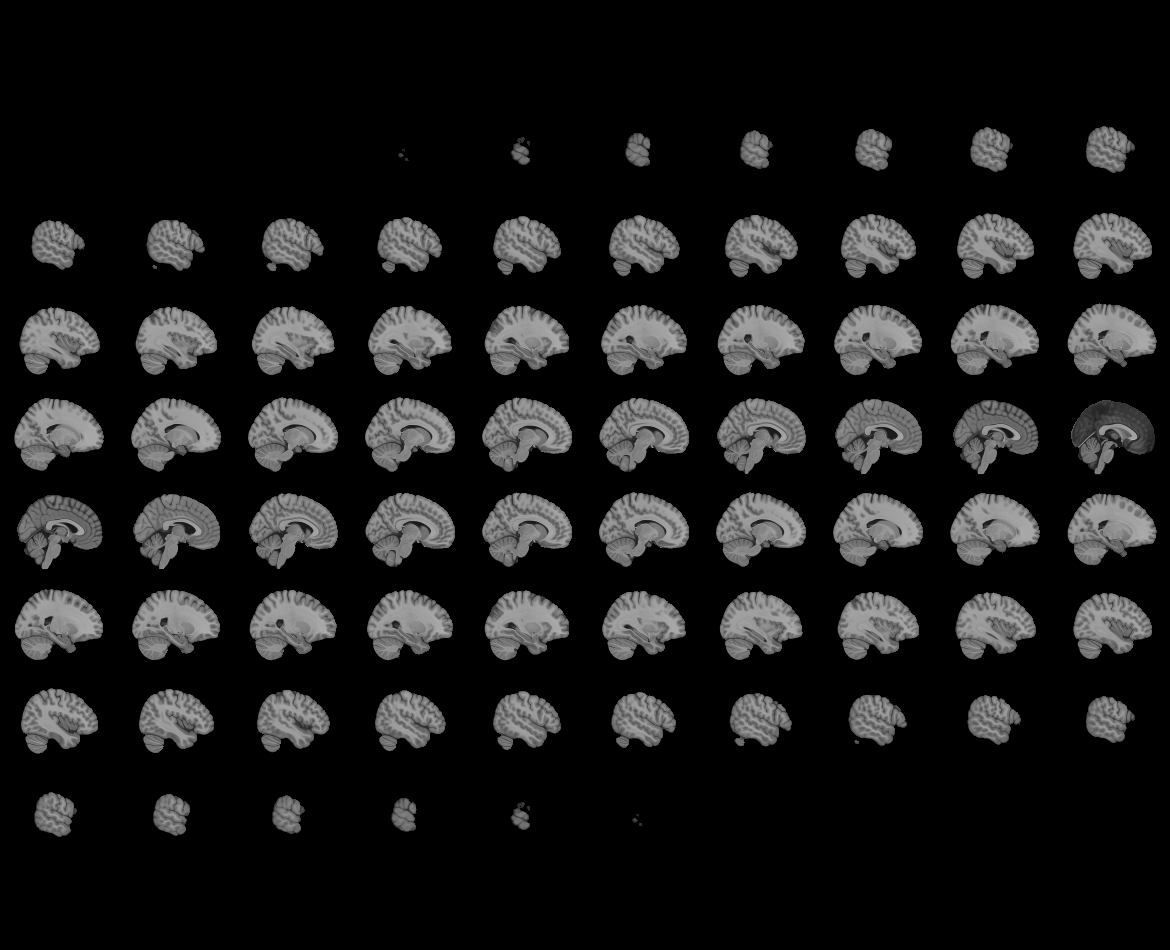
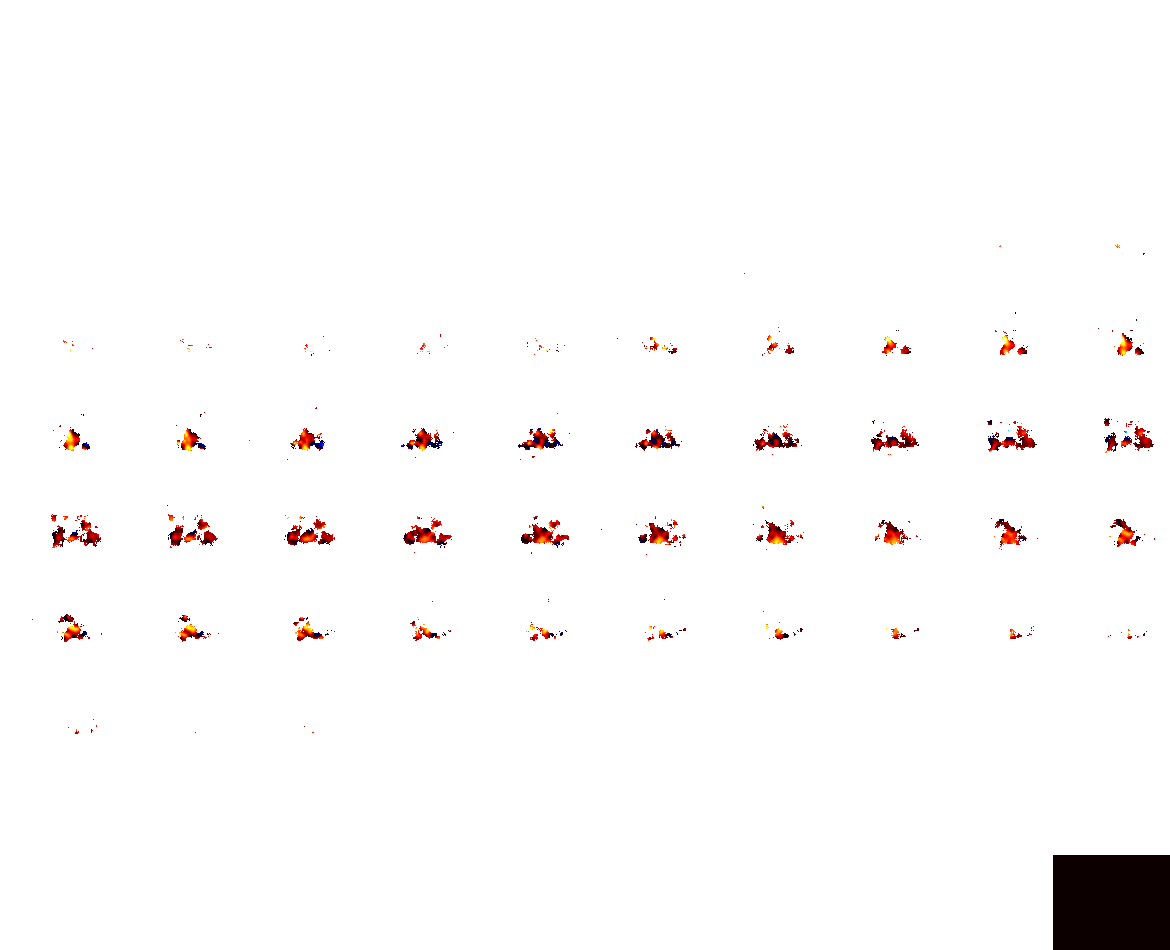

In [17]:
nlp.view_img(stat_maps_paired_masked['z_score'], colorbar=True)

In [18]:
# threshold image
ct = 10
alpha = 0.05
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired_masked['z_score'], cluster_threshold=ct, alpha=alpha, height_control=hc)

In [19]:
table_g,cluster_map_g = get_clusters_table(stat_maps_paired_masked['z_score'], stat_threshold=thres, cluster_threshold=ct,
                                return_label_maps=True)

# AAL3 labelling
coordinates = table_g[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table_g['AAL3'] = aal_labels
table_g

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,-20.0,2.0,8.0,3.312336,1296,Putamen_L
1,2,24.0,8.0,2.0,2.707735,1184,Putamen_R
2,2a,30.0,18.0,-6.0,2.428680,,Undefined
3,3,-18.0,6.0,-18.0,2.684071,992,Olfactory_L
4,4,34.0,-4.0,0.0,2.554039,176,Putamen_R
5,5,14.0,14.0,-20.0,2.512648,560,OFCmed_R
6,5a,16.0,22.0,-18.0,2.109250,,OFCmed_R
7,6,40.0,14.0,-14.0,2.409467,80,Insula_R
8,7,-14.0,-14.0,-10.0,2.364372,104,SN_pr_L


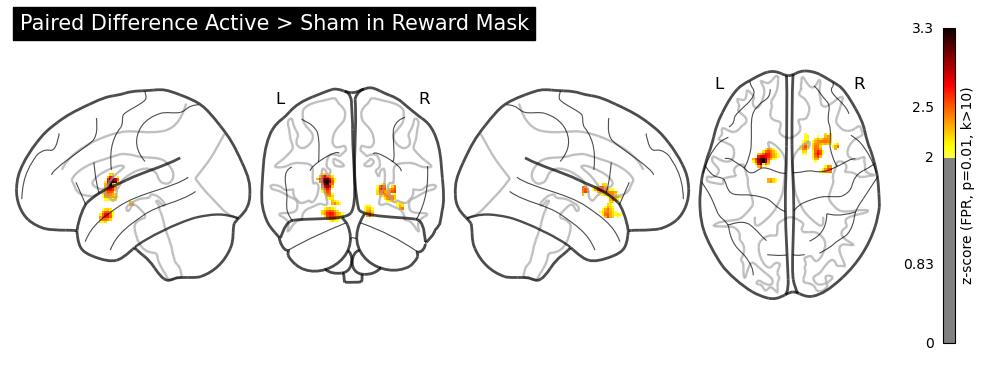

In [20]:
display = nlp.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    display_mode='lyrz', 
    title='Paired Difference Active > Sham in Reward Mask', 
)

# Add colorbar text
colorbar = display._cbar
colorbar.set_label('z-score (FPR, p=0.01, k>10)')

In [21]:
import nibabel as nib

A = corrected_map.get_fdata()

sig_voxels = A > 0.0001

# average all non-zero values of A
B = np.mean(A[sig_voxels])
print(f"Average z-score in ROI: {B}")

C = stat_maps_paired_masked['p_value'].get_fdata()

print(f"Average p-value of significant voxels: {np.mean(C[sig_voxels])}")

Average z-score in ROI: 2.257228750508918
Average p-value of significant voxels: 0.013752130651410916


# Target ROI from BrainVoyager

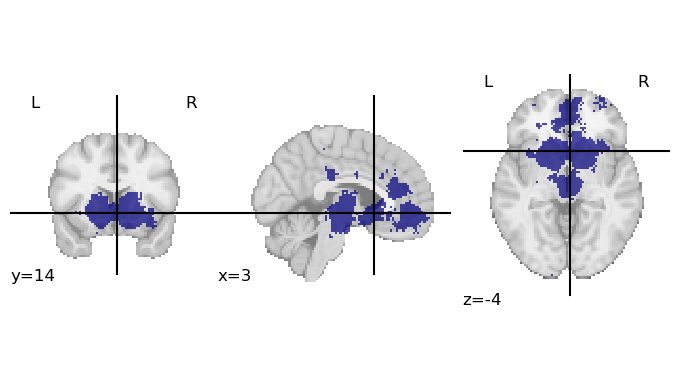

In [22]:
nii_path = '/Volumes/T7/BIDS-MUSICNF/derivatives/tbv-vois/MPM_targets_prob-map_region-labels.nii.gz'

roi_bin2 = math_img("img > 0", img=nii_path)
nlp.plot_roi(roi_bin)

In [23]:
second_level_model_paired_masked2 = SecondLevelModel(n_jobs=2, smoothing_fwhm=8, mask_img=roi_bin2).fit(
    second_level_input, design_matrix=paired_design_matrix
)

stat_maps_paired_masked2 = second_level_model_paired_masked2.compute_contrast(
    "activeVSsham", output_type="all"
)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



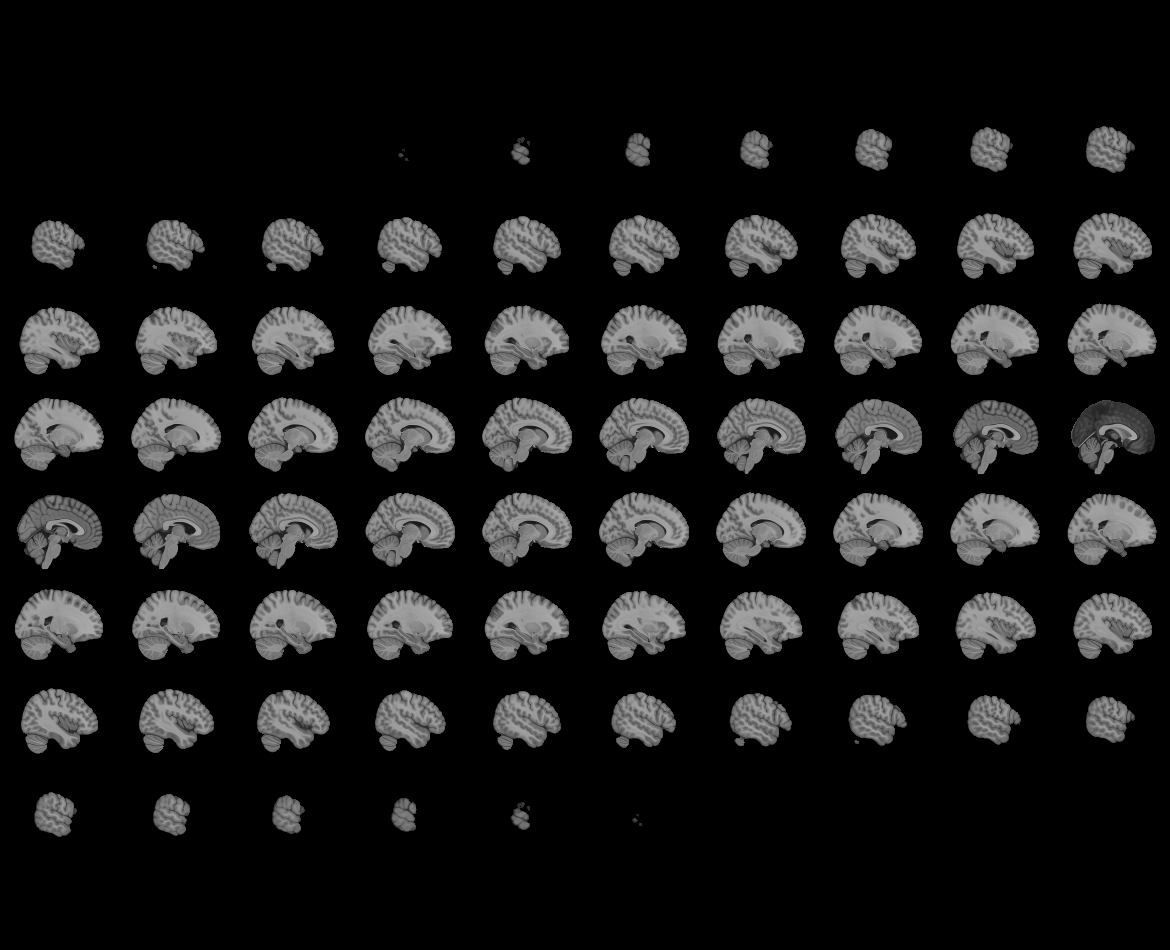
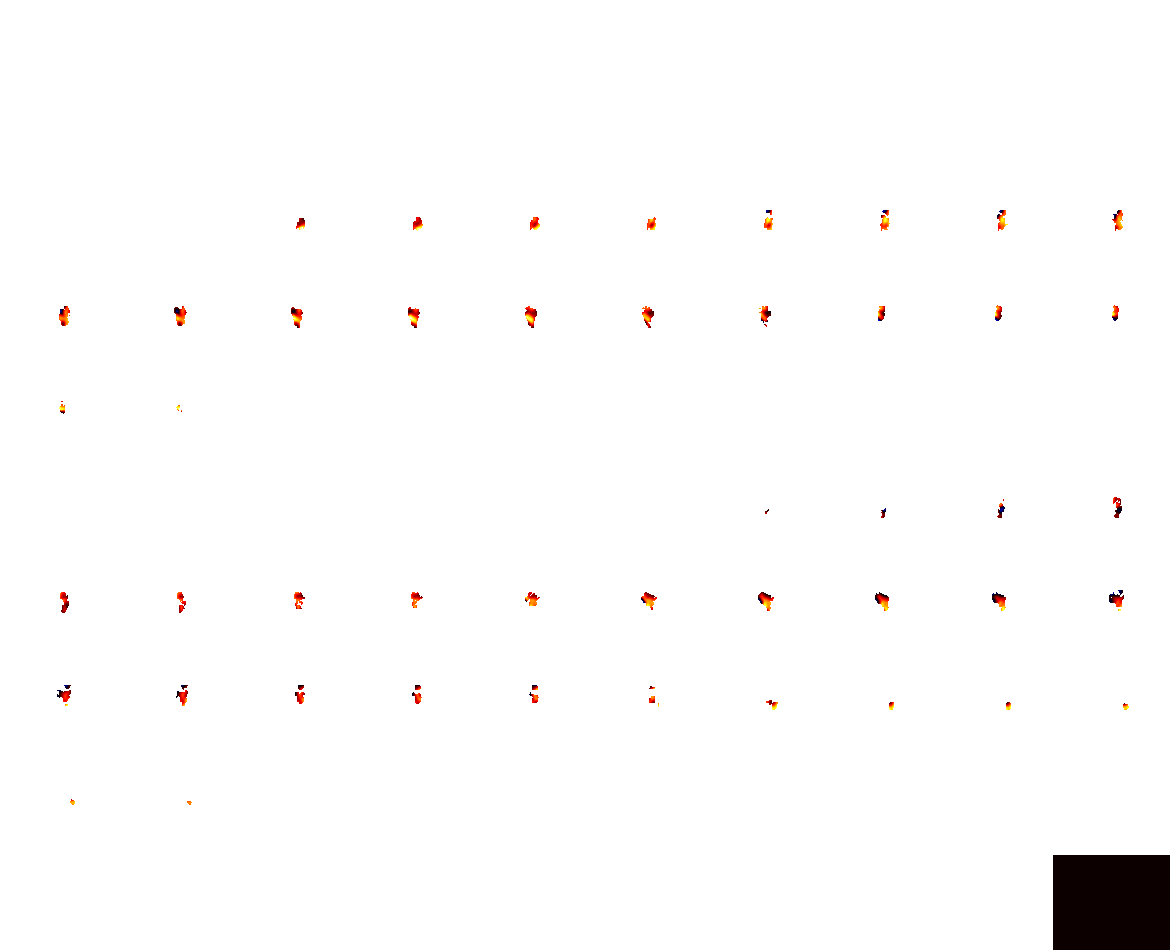

In [24]:
nlp.view_img(stat_maps_paired_masked2['z_score'], colorbar=True)

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



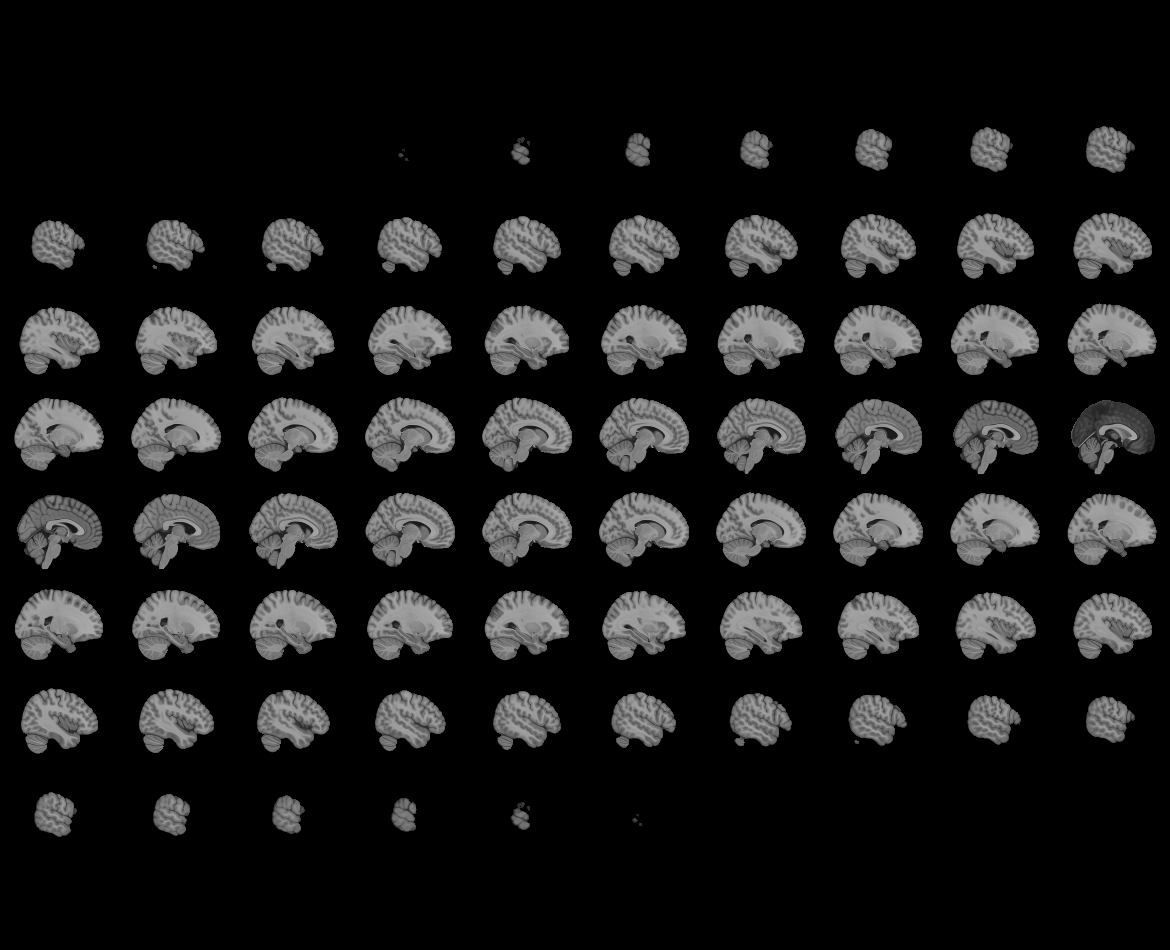
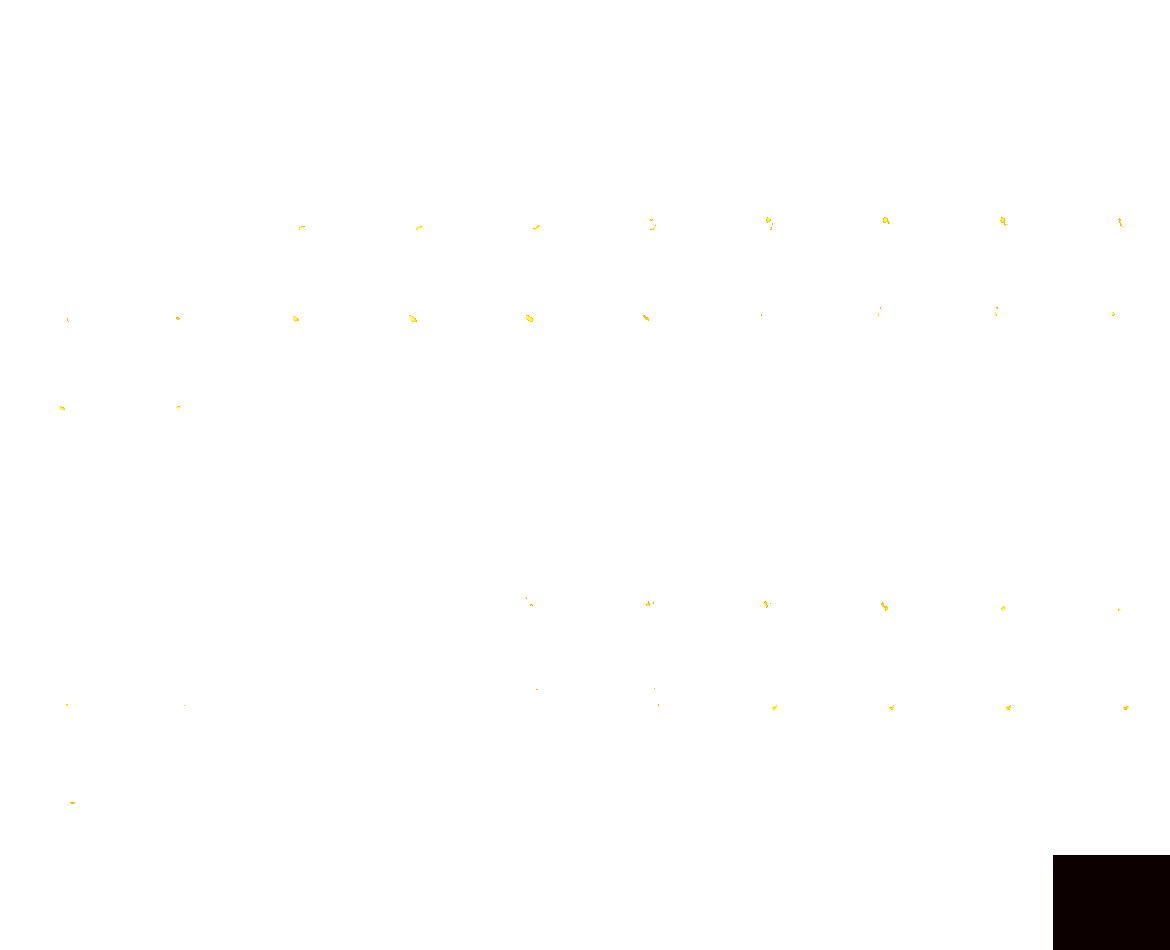

In [25]:
# threshold image
ct = 10
alpha = 0.05
hc = 'fpr'

corrected_map, thres = threshold_stats_img(stat_maps_paired_masked2['z_score'], cluster_threshold=ct, alpha=alpha, height_control=hc)

nlp.view_img(corrected_map, threshold=thres, colorbar=True)

In [26]:
import nibabel as nib

A = corrected_map.get_fdata()

sig_voxels = A > 0.0001

# average all non-zero values of A
B = np.mean(A[sig_voxels])

print(f"Average z-score of significant voxels: {B}")

Average z-score of significant voxels: 2.246555629421729


In [27]:
C = stat_maps_paired_masked2['p_value'].get_fdata()

print(f"Average p-value of significant voxels: {np.mean(C[sig_voxels])}")

Average p-value of significant voxels: 0.01404361909996566
